# Task 2: 

# Data Preprocessing
## Importing the data
For task 2, we will only be taking the image data that is known to come from four categories of 1, 2, 5, and 13. And we will train and test among this subset of data. We will do the similar data preprocessing procedures. Like we did in the task 1 with data augementation of category 5 because it has signifcantly smaller sample size. And we will perform the normalization like before.

In [1]:
from util_copy import load_fabric_data, extract_label_grouping, extract_label_grouping, load_fabric_images
import numpy as np
from matplotlib import image

Import the dataset by loading the images and label data. 

In [2]:
path = r"C:/Users/Administrator/Desktop/PRML/Project/fabric_data/label_json/**/**.json"

fids, fdata = load_fabric_data(path)
ftype1, ftype2 = extract_label_grouping(fdata)

path = r"C:/Users/Administrator/Desktop/PRML/Project/fabric_data/temp/"
labels, imgs = load_fabric_images(path, fids, fdata, ftype1)

import cv2
imgs = [cv2.resize(img,(200, 200)) for img in imgs]

Now we will only take the data set of the four categoires/ 

In [3]:
# another way of selecting categories
from numpy import array

# find the indcies of the catgory 1, 2, 5, 13
def find_indices_four_cat(listOfLabel):
    res = []
    i = 0 
    for i in range(0,len(listOfLabel)):
        if (listOfLabel[i] == 1) or (listOfLabel[i]== 2) or (listOfLabel[i] == 5) or (listOfLabel[i] == 13): 
            res.append(i)
    return res

label_four_cat_indices = find_indices_four_cat(labels)

# select the fours category out of the sample 
labels_four_cat = array(labels)[label_four_cat_indices]
samples_four_cat = array(imgs)[label_four_cat_indices]

## Splitting the data

We will perform two splitting in the same way we did in task 1. Here is the first split 

In [4]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(samples_four_cat, labels_four_cat, test_size=0.2, random_state=1)

Then before we further spliting the training data into training data and validation data. We want to check the frequency distributions of all the labels 

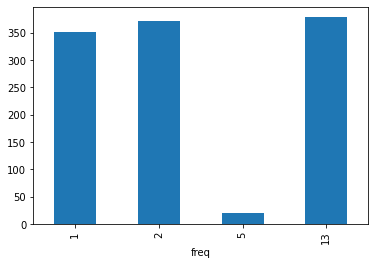

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# output the frequency of the original training data 
df = pd.DataFrame({'freq': labels_four_cat})
df.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()

We see category 5 has significant fewer amount of frequency distribution. We decide to generate some "fake" training data for category five.

## Data Augementation 


In [6]:
# subset all the 5s 
def find_indices_5(listOfLabel):
    res = []
    i = 0 
    for i in range(0,len(listOfLabel)):
        if (listOfLabel[i] == 5): 
            res.append(i)
    return res

label_five = find_indices_5(train_labels)
print(len(label_five))

train_is_five = array(train_images)[label_five]

# Data augementation 
# generate more category FIVE

def rotate_a_bunch(a_list_of_image):
    res = []
    for i in range(0, len(a_list_of_image)):
        rotate_once1 = np.rot90(a_list_of_image[i], k=1, axes=(0, 1))
        a = rotate_once1[::-1]
        rotate_twice1 = np.rot90(rotate_once1, k=1, axes=(0, 1))
        b = rotate_twice1[::-1]
        rotate_third1 = np.rot90(rotate_twice1, k=1, axes=(0, 1))
        c = rotate_third1[::-1]
        rotate_once2 = np.rot90(a_list_of_image[i], k=1, axes=(1, 0))
        d= rotate_once2[::-1]
        rotate_twice2 = np.rot90(rotate_once2, k=1, axes=(1, 0))
        e = rotate_twice2[::-1]
        rotate_third2 = np.rot90(rotate_twice2, k=1, axes=(1, 0))
        f = rotate_third2[::-1]
        
        new_gen = [rotate_once1,rotate_once2, rotate_twice1,rotate_twice2,rotate_third1, rotate_third2 ]
        new_gen2 = [a,b,c,d,e,f]
        res= new_gen + res + new_gen2
    return np.array(res) 

# the generated new image data
generated_5 = rotate_a_bunch(train_is_five)

generated_5_label = [5] * len(generated_5)

# create the new training data set (note test data set is already seperated out before hand)
train_images = np.concatenate((train_images , generated_5)) 
train_labels =  np.concatenate((train_labels , generated_5_label))

13


Now we concatenate all the training images together with the new image data generated with the order preserved. We can take a look at the frequency distribution of the new training data set (with validation set included). 

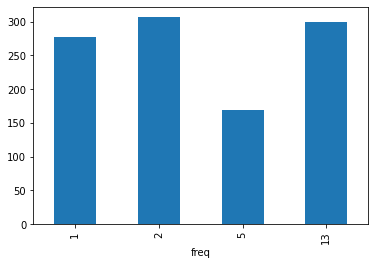

In [7]:
# output the new frequency 
df = pd.DataFrame({'freq': train_labels})
df.groupby('freq', as_index=False).size().plot(kind='bar')
plt.show()

So the imbalance of the training sample seems to be eased up a little, although group 5 still has significantly fewer training size than others. 

## Splitting the training and validation set 
We will now split the new training set in to actual training set and the validation set. The validation set is used to fine tune our model along the way. 

In [8]:
train1_images , val_images, train1_labels , val_labels =  train_test_split(train_images, train_labels, test_size=0.2, random_state=1)

## Normalize the image data
We will normalize the data by dividing 255. 

In [9]:
train1_images = train1_images / 255.0 
val_images    = val_images / 255.0 


In [10]:
test_images = np.array(test_images)/ 255.0

So now we can take a look at the size of each splitted data set. 

In [11]:
print("#Training data: {}\n #Validation data: {}\n #Testing data: {}\n#Class: {}".format(len(train1_images), len(val_images), len(test_images), len(set(train_labels))))

#Training data: 843
 #Validation data: 211
 #Testing data: 225
#Class: 4


## Change the category number
There is one extra step before moving into our CNN algoirthm is that we need to renameing the category. Because now the category number are 1,2,5,12 which can consue the integer representation of catgeory. So we are going to each each category to 0, 1, 2, 3 respectively. 

In [12]:
# rename 1,2,5,12 category number to 0 1 2 3 
def change_cat_number(list_1):
    for i in range(0,len(list_1)):
        if list_1[i] == 1:
            list_1[i] = 0
        elif list_1[i] == 2:
            list_1[i] = 1
        elif list_1[i] == 5:
            list_1[i] = 2
        else: 
            list_1[i] = 3
    return list_1

train1_labels = change_cat_number(train1_labels)
val_labels= change_cat_number(val_labels)
test_labels = change_cat_number(test_labels)

# Implementation 

We will start building our Convolutional Neurel Network model and more specifically an AlexNet 

In [13]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

We will be using the same Alex Net Model from the previous task. 

In [14]:
num_classes = len(set(train1_labels))

# AlexNet model
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))
   
        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dropout(0.1))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.0001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

Now we will compile our model and take a look at the summary of the layers information 

In [15]:
model = AlexNet((200, 200, 6), num_classes)
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 96)        69792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 256)       884

In [16]:
# start training
history = model.fit(train1_images, train1_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

Epoch 1/10
27/27 [==============================] - 75s 3s/step - loss: 1.5577 - accuracy: 0.3416 - val_loss: 1.2298 - val_accuracy: 0.4408
Epoch 2/10
27/27 [==============================] - 71s 3s/step - loss: 1.1598 - accuracy: 0.4804 - val_loss: 1.1069 - val_accuracy: 0.4834
Epoch 3/10
27/27 [==============================] - 73s 3s/step - loss: 1.0378 - accuracy: 0.5326 - val_loss: 1.0820 - val_accuracy: 0.5213
Epoch 4/10
27/27 [==============================] - 71s 3s/step - loss: 0.9101 - accuracy: 0.6287 - val_loss: 1.0659 - val_accuracy: 0.5640
Epoch 5/10
27/27 [==============================] - 70s 3s/step - loss: 0.7406 - accuracy: 0.6975 - val_loss: 1.1305 - val_accuracy: 0.5640
Epoch 6/10
27/27 [==============================] - 70s 3s/step - loss: 0.6321 - accuracy: 0.7592 - val_loss: 0.8912 - val_accuracy: 0.6825
Epoch 7/10
27/27 [==============================] - 71s 3s/step - loss: 0.4245 - accuracy: 0.8363 - val_loss: 0.9104 - val_accuracy: 0.7299
Epoch 8/10
27/27 [==

# Results and Analysis

We can graph the performance of the training over the 10 epochs below:

7/7 - 4s - loss: 0.7105 - accuracy: 0.8057


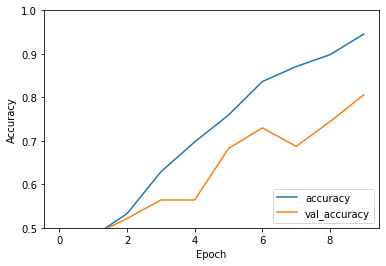

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_images,  val_labels, verbose=2)

We see that the accuracy and validated accuracy doesn't seem to converge. 

Then we can make the predictionss with the following: 

In [18]:
# make prediction
predicted_label = model.predict_classes(test_images)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Then we can draw the confusion matrix. The following section of code is origianlly from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [19]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

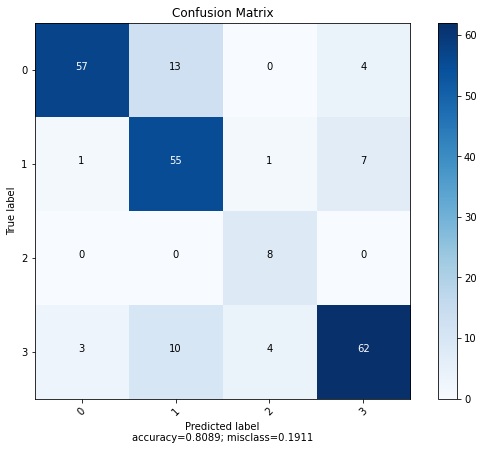

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

plot_confusion_matrix(cm           = confusion_matrix(test_labels, predicted_label), 
                      normalize    = False,
                      target_names = [0,1,2,3],
                      title        = "Confusion Matrix")

In [23]:
print(classification_report(test_labels, predicted_label))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84        74
           1       0.71      0.86      0.77        64
           2       0.62      1.00      0.76         8
           3       0.85      0.78      0.82        79

    accuracy                           0.81       225
   macro avg       0.78      0.85      0.80       225
weighted avg       0.83      0.81      0.81       225



##### Reason why accuracy doesn't further increase
1. imbalance of trianing set 
2. learning rate too large 